<a href="https://colab.research.google.com/github/UtkarshAIITB/IPL-Data-Analysis/blob/main/ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
svr = SVR()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ball = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IPL Score_Analysis/CSV/IPL Ball-by-Ball 2008-2020.csv')
print(ball.shape)
ball.head() 

(193468, 18)


,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,335982,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
2,335982,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
3,335982,1,7,2,BB McCullum,RT Ponting,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
4,335982,1,7,3,RT Ponting,BB McCullum,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore


In [5]:
match = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IPL Score_Analysis/CSV/IPL Matches 2008-2020.csv')
print(match.shape)
match.head() 

(816, 17)


,id,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2
0,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,Chandigarh,2008-04-19,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,N,NaN,MR Benson,SL Shastri
2,335984,Delhi,2008-04-19,MF Maharoof,Feroz Shah Kotla,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,Mumbai,2008-04-20,MV Boucher,Wankhede Stadium,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,N,NaN,SJ Davis,DJ Harper
4,335986,Kolkata,2008-04-20,DJ Hussey,Eden Gardens,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,N,NaN,BF Bowden,K Hariharan


In [6]:
df = pd.merge(match , ball, on='id', how = 'right')
print(df.shape)
df.head()

(193468, 34)


,id,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
2,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
3,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen,1,7,2,BB McCullum,RT Ponting,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
4,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen,1,7,3,RT Ponting,BB McCullum,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore


## Pre-processing

### Converting names of the teams

In [7]:
df = df.replace(['Rising Pune Supergiant' , 'Delhi Daredevils'], ['Rising Pune Supergiants' , 'Delhi Capitals'])

In [8]:
df['year'] = pd.DatetimeIndex(df['date']).year
# data['year'] = pd.DatetimeIndex(data['date']).year
df.head()

,id,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team,year
0,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore,2008
1,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore,2008
2,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore,2008
3,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen,1,7,2,BB McCullum,RT Ponting,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore,2008
4,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen,1,7,3,RT Ponting,BB McCullum,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore,2008


Dropping unnecessary columns

In [9]:
columns = ['neutral_venue', 'result', 'result_margin', 'umpire1', 'umpire2', 'batsman', 'non_striker', 'bowler', 'non_boundary', 'dismissal_kind',
           'player_dismissed', 'fielder', 'extras_type', 'player_of_match', 'venue', 'city']
df_run = df.drop(columns = columns)
df_run.head()

,id,date,team1,team2,toss_winner,toss_decision,winner,eliminator,method,inning,over,ball,batsman_runs,extra_runs,total_runs,is_wicket,batting_team,bowling_team,year
0,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,NaN,1,6,5,1,0,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
1,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,NaN,1,6,6,1,0,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
2,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,NaN,1,7,1,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
3,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,NaN,1,7,2,1,0,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
4,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,NaN,1,7,3,1,0,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008


In [10]:
df_run['method']  = df_run['method'].fillna('Normal')
df_run.head()

,id,date,team1,team2,toss_winner,toss_decision,winner,eliminator,method,inning,over,ball,batsman_runs,extra_runs,total_runs,is_wicket,batting_team,bowling_team,year
0,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,Normal,1,6,5,1,0,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
1,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,Normal,1,6,6,1,0,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
2,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,Normal,1,7,1,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
3,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,Normal,1,7,2,1,0,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
4,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,Normal,1,7,3,1,0,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008


In [11]:
winner_null = df_run[df_run['winner'].isna()]
df_run = df_run.dropna()

In [12]:
df_sort = df_run.sort_values(by = ['id', 'inning', 'over', 'ball'])
df_sort = df_sort.reset_index()
df_sort = df_sort.drop(columns = 'index')
df_sort.head()

,id,date,team1,team2,toss_winner,toss_decision,winner,eliminator,method,inning,over,ball,batsman_runs,extra_runs,total_runs,is_wicket,batting_team,bowling_team,year
0,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,Normal,1,0,1,0,1,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
1,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,Normal,1,0,2,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
2,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,Normal,1,0,3,0,1,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
3,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,Normal,1,0,4,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008
4,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,N,Normal,1,0,5,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008


### One Hot encoding of toss decision, method and eliminator

In [13]:
dummy_td = pd.get_dummies(df_sort.toss_decision)
df_enc = pd.concat([df_sort, dummy_td], axis = 'columns')                     #encoded toss decisions - field or bat
df_enc = df_enc.drop(columns = ['toss_decision', 'bat'])
# df_enc.head()
dummy_td = pd.get_dummies(df_sort.method)
df_enc = pd.concat([df_enc, dummy_td], axis = 'columns')
df_enc = df_enc.drop(columns = ['method', 'Normal'])                          #encoded method - normal or D/L
# df_enc.head()
dummy_td = pd.get_dummies(df_sort.eliminator)
dummy_td.rename(columns = {'Y': 'eliminator?' }, inplace = True )
df_enc = pd.concat([df_enc, dummy_td], axis = 'columns')
df_enc = df_enc.drop(columns = ['eliminator', 'N'])  
df_enc.head()

,id,date,team1,team2,toss_winner,winner,inning,over,ball,batsman_runs,extra_runs,total_runs,is_wicket,batting_team,bowling_team,year,field,D/L,eliminator?
0,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,1,0,1,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0
1,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,2,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0
2,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,3,0,1,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0
3,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,4,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0
4,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,5,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0


In [14]:
df_enc['inning_bat'] = df_enc['id'].astype(str)+(df_enc['batting_team']).astype(str)
df_enc.head()

,id,date,team1,team2,toss_winner,winner,inning,over,ball,batsman_runs,extra_runs,total_runs,is_wicket,batting_team,bowling_team,year,field,D/L,eliminator?,inning_bat
0,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,1,0,1,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0,335982Kolkata Knight Riders
1,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,2,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0,335982Kolkata Knight Riders
2,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,3,0,1,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0,335982Kolkata Knight Riders
3,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,4,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0,335982Kolkata Knight Riders
4,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,5,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0,335982Kolkata Knight Riders


In [15]:
list1 = df_enc['inning_bat'].unique()
df_copy = df_enc.copy()
df_copy = df_copy.groupby(by = ['inning_bat']).sum()['total_runs'].reset_index()
data = pd.merge(left=df_enc, right=df_copy, on='inning_bat', how='right')
print(data.shape)
data.head()

(193096, 21)


,id,date,team1,team2,toss_winner,winner,inning,over,ball,batsman_runs,extra_runs,total_runs_x,is_wicket,batting_team,bowling_team,year,field,D/L,eliminator?,inning_bat,total_runs_y
0,1082591,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,2,0,1,1,0,1,0,Royal Challengers Bangalore,Sunrisers Hyderabad,2017,1,0,0,1082591Royal Challengers Bangalore,172
1,1082591,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,2,0,2,0,0,0,0,Royal Challengers Bangalore,Sunrisers Hyderabad,2017,1,0,0,1082591Royal Challengers Bangalore,172
2,1082591,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,2,0,3,0,0,0,0,Royal Challengers Bangalore,Sunrisers Hyderabad,2017,1,0,0,1082591Royal Challengers Bangalore,172
3,1082591,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,2,0,4,2,0,2,0,Royal Challengers Bangalore,Sunrisers Hyderabad,2017,1,0,0,1082591Royal Challengers Bangalore,172
4,1082591,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,2,0,5,4,0,4,0,Royal Challengers Bangalore,Sunrisers Hyderabad,2017,1,0,0,1082591Royal Challengers Bangalore,172


In [16]:
data['over'] = data['over']+ (data['ball'])/10
data.drop(columns = ['ball'], inplace = True)
print(data.shape)
data.head()

(193096, 20)


,id,date,team1,team2,toss_winner,winner,inning,over,batsman_runs,extra_runs,total_runs_x,is_wicket,batting_team,bowling_team,year,field,D/L,eliminator?,inning_bat,total_runs_y
0,1082591,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,2,0.1,1,0,1,0,Royal Challengers Bangalore,Sunrisers Hyderabad,2017,1,0,0,1082591Royal Challengers Bangalore,172
1,1082591,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,2,0.2,0,0,0,0,Royal Challengers Bangalore,Sunrisers Hyderabad,2017,1,0,0,1082591Royal Challengers Bangalore,172
2,1082591,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,2,0.3,0,0,0,0,Royal Challengers Bangalore,Sunrisers Hyderabad,2017,1,0,0,1082591Royal Challengers Bangalore,172
3,1082591,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,2,0.4,2,0,2,0,Royal Challengers Bangalore,Sunrisers Hyderabad,2017,1,0,0,1082591Royal Challengers Bangalore,172
4,1082591,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,Sunrisers Hyderabad,2,0.5,4,0,4,0,Royal Challengers Bangalore,Sunrisers Hyderabad,2017,1,0,0,1082591Royal Challengers Bangalore,172


### Finding total runs

In [17]:
df_final = pd.DataFrame()
for bat in list1:
  inning  = data[data['inning_bat']==bat].copy()
  # inning.head()
  cum_total  = inning.loc[:,'total_runs_x'].cumsum(axis = 0)
  inning['cum_total'] = cum_total
  cum_wicket = inning.loc[:,'is_wicket'].cumsum(axis = 0)
  inning['cum_wicket'] = cum_wicket
  # inning.head()
  df_final = df_final.append(inning, ignore_index=True)

In [18]:
df_final.head()

,id,date,team1,team2,toss_winner,winner,inning,over,batsman_runs,extra_runs,total_runs_x,is_wicket,batting_team,bowling_team,year,field,D/L,eliminator?,inning_bat,total_runs_y,cum_total,cum_wicket
0,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0.1,0,1,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0,335982Kolkata Knight Riders,222,1,0
1,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0.2,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0,335982Kolkata Knight Riders,222,1,0
2,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0.3,0,1,1,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0,335982Kolkata Knight Riders,222,2,0
3,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0.4,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0,335982Kolkata Knight Riders,222,2,0
4,335982,2008-04-18,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,1,0.5,0,0,0,0,Kolkata Knight Riders,Royal Challengers Bangalore,2008,1,0,0,335982Kolkata Knight Riders,222,2,0


### Label encoding
Teams are label encoded in order of their strength analysed from EDA

In [19]:
team_dict = {'Mumbai Indians':13, 'Chennai Super Kings':12, 'Rajasthan Royals':11, 'Rising Pune Supergiants':10 ,'Kolkata Knight Riders':9, 'Kings XI Punjab':8,
             'Sunrisers Hyderabad':7, 'Delhi Capitals':6, 'Royal Challengers Bangalore':5, 'Gujarat Lions':4, 'Deccan Chargers':3,
             'Pune Warriors':2, 'Kochi Tuskers Kerala':1
             }

In [20]:
bore = df_final.copy()
bore['team1'] = bore.team1.map(team_dict)
bore['team2'] = bore.team2.map(team_dict)
bore['toss_winner'] = bore.toss_winner.map(team_dict)
bore['winner'] = bore.winner.map(team_dict)
bore['batting_team'] = bore.batting_team.map(team_dict)
bore['bowling_team'] = bore.bowling_team.map(team_dict)
bore.head()

,id,date,team1,team2,toss_winner,winner,inning,over,batsman_runs,extra_runs,total_runs_x,is_wicket,batting_team,bowling_team,year,field,D/L,eliminator?,inning_bat,total_runs_y,cum_total,cum_wicket
0,335982,2008-04-18,5,9,5,9,1,0.1,0,1,1,0,9,5,2008,1,0,0,335982Kolkata Knight Riders,222,1,0
1,335982,2008-04-18,5,9,5,9,1,0.2,0,0,0,0,9,5,2008,1,0,0,335982Kolkata Knight Riders,222,1,0
2,335982,2008-04-18,5,9,5,9,1,0.3,0,1,1,0,9,5,2008,1,0,0,335982Kolkata Knight Riders,222,2,0
3,335982,2008-04-18,5,9,5,9,1,0.4,0,0,0,0,9,5,2008,1,0,0,335982Kolkata Knight Riders,222,2,0
4,335982,2008-04-18,5,9,5,9,1,0.5,0,0,0,0,9,5,2008,1,0,0,335982Kolkata Knight Riders,222,2,0


In [21]:
bore.drop(columns = ['extra_runs', 'inning_bat', 'batsman_runs', 'total_runs_x', 'is_wicket'], inplace = True)
bore.head()

,id,date,team1,team2,toss_winner,winner,inning,over,batting_team,bowling_team,year,field,D/L,eliminator?,total_runs_y,cum_total,cum_wicket
0,335982,2008-04-18,5,9,5,9,1,0.1,9,5,2008,1,0,0,222,1,0
1,335982,2008-04-18,5,9,5,9,1,0.2,9,5,2008,1,0,0,222,1,0
2,335982,2008-04-18,5,9,5,9,1,0.3,9,5,2008,1,0,0,222,2,0
3,335982,2008-04-18,5,9,5,9,1,0.4,9,5,2008,1,0,0,222,2,0
4,335982,2008-04-18,5,9,5,9,1,0.5,9,5,2008,1,0,0,222,2,0


In [22]:
test_set = bore[bore.year == 2019]
test_set.head()

,id,date,team1,team2,toss_winner,winner,inning,over,batting_team,bowling_team,year,field,D/L,eliminator?,total_runs_y,cum_total,cum_wicket
164344,1175356,2019-03-23,12,5,12,12,1,0.1,5,12,2019,1,0,0,70,1,0
164345,1175356,2019-03-23,12,5,12,12,1,0.2,5,12,2019,1,0,0,70,1,0
164346,1175356,2019-03-23,12,5,12,12,1,0.3,5,12,2019,1,0,0,70,1,0
164347,1175356,2019-03-23,12,5,12,12,1,0.4,5,12,2019,1,0,0,70,1,0
164348,1175356,2019-03-23,12,5,12,12,1,0.5,5,12,2019,1,0,0,70,5,0


test_set contains complete IPL data for the year 2019.
We will train the model on the data from the year 2008-2020

In [23]:
bore.drop(bore[bore.year == 2019].index, inplace = True)
print(bore.shape)

(178854, 17)


In [24]:
demo = bore[bore.year == 2019]
demo.head()
#as expected demo is empty.

,id,date,team1,team2,toss_winner,winner,inning,over,batting_team,bowling_team,year,field,D/L,eliminator?,total_runs_y,cum_total,cum_wicket


## Accuracy Model

In [25]:
def custom_accuracy(y_test,y_pred,thresold):
    right = 0
    l = len(y_pred)
    for i in range(0,l):
        if(abs(y_pred[i]-y_test[i]) <= thresold):
            right += 1
    return ((right/l)*100)

def mse(y_test,y_pred):
    return (mean_squared_error(y_test,y_pred))

def r2(y_test,y_pred):
    return (r2_score(y_test,y_pred))

In [26]:
go = bore.copy()

## Total Runs Function

In [27]:
def new_strat(y_pred, y_test):
  sample = pd.DataFrame(y_pred,columns=['Predict'])
  sample['Actual']=y_test
  ar1 = sample['Actual'].unique()
  results = pd.DataFrame()
  for items in ar1:
    # print(items)
    try2 = sample[sample.Actual == items]
    result = (try2.sum())/try2.shape[0]
    # print(result)
    res = result.values.reshape(1,2)
    # print(res)
    results = results.append(pd.DataFrame(res))

  results.rename(columns = {0: 'Predict',
                            1: 'Actual'
                            }, inplace = True)
  results.reset_index(drop = True)
  mean_sq_err = mse(results['Actual'].ravel(), results['Predict'].ravel())
  r2score  = r2(results['Actual'].ravel(), results['Predict'].ravel())
  accu = (custom_accuracy(results['Actual'].ravel(),results['Predict'].ravel(),12))
  return(accu, results, mean_sq_err, r2score)

# Runs prediction - Primary Models

In [28]:
y1 = go['winner']
y2 = go['total_runs_y'] 
X = go.drop(columns = ['id', 'date', 'winner', 'total_runs_y','year'])

In [29]:
X.head()

,team1,team2,toss_winner,inning,over,batting_team,bowling_team,field,D/L,eliminator?,cum_total,cum_wicket
0,5,9,5,1,0.1,9,5,1,0,0,1,0
1,5,9,5,1,0.2,9,5,1,0,0,1,0
2,5,9,5,1,0.3,9,5,1,0,0,2,0
3,5,9,5,1,0.4,9,5,1,0,0,2,0
4,5,9,5,1,0.5,9,5,1,0,0,2,0


In [30]:
test = test_set.copy()
y1_test = test['winner']
y2_test = test['total_runs_y']
X_test = test.drop(columns = ['id', 'date', 'winner', 'total_runs_y','year'])

In [31]:
X_test.reset_index().drop(columns = ['index']).head()

,team1,team2,toss_winner,inning,over,batting_team,bowling_team,field,D/L,eliminator?,cum_total,cum_wicket
0,12,5,12,1,0.1,5,12,1,0,0,1,0
1,12,5,12,1,0.2,5,12,1,0,0,1,0
2,12,5,12,1,0.3,5,12,1,0,0,1,0
3,12,5,12,1,0.4,5,12,1,0,0,1,0
4,12,5,12,1,0.5,5,12,1,0,0,5,0


In [32]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

## Complete Data

### Random Forest

In [33]:
%%time
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X, y2)
y_pred = rf.predict(X_test)
y2_test = y2_test.ravel()
print("Custom accuracy: {:.3f} %".format(custom_accuracy(y2_test,y_pred,10)))

Custom accuracy: 2.521 %
CPU times: user 59.6 s, sys: 358 ms, total: 1min
Wall time: 59.8 s


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names



### Linear Regression

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
lr = LinearRegression()
lr.fit(X, y2)
y_pred = lr.predict(X_test)
print("Custom accuracy: {:.3f} %".format(custom_accuracy(y2_test,y_pred,10)))

Custom accuracy: 0.000 %


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



As it can be seen clearly, both the regressors dint work. Since the data is too much, so its highly overfitting. So lets try out training the model on a particular ball.

## Particular ball

So since overall our model failed, lets train the model ball by ball and check in which range of overs the model performs best. By domain knowledge, it mustn't be good for first 6-7 overs since that has very little to do with teams total score

In [36]:
def accurate(ball, threshold):
  bb = bore[bore.over == ball]
  bb_test = test_set[test_set.over == ball]
  y1 = bb['winner']
  y2 = bb['total_runs_y']
  X = bb.drop(columns = ['winner', 'total_runs_y', 'year','id', 'date']).reset_index(drop = True)
  y1_test = bb_test['winner']
  y2_test = bb_test['total_runs_y']
  X_test = bb_test.drop(columns = ['winner', 'total_runs_y', 'year','id', 'date']).reset_index(drop = True)
  X_trans = sc.fit_transform(X)
  X_trans_test = sc.fit_transform(X_test)
  svr.fit(X_trans,y2)
  y_pred = svr.predict(X_trans_test)
  y2_test = y2_test.ravel()
  print('Accuracy in ball '+str(ball)+' is ' + str(custom_accuracy(y2_test, y_pred, threshold)) + '% in SVR')
  rf.fit(X_trans,y2)
  y_pred = rf.predict(X_trans_test)
  print('Accuracy in ball '+str(ball)+' is ' + str(custom_accuracy(y2_test, y_pred, threshold)) + '% in RF')

In [37]:
list3 = bore['over'].unique()
list4 = test['over'].unique()
set3 = set(list3)
set4 = set(list4)
for ball in (set3 & set4):
  accurate(ball,12)

Accuracy in ball 0.5 is 28.8135593220339% in SVR
Accuracy in ball 0.5 is 31.35593220338983% in RF
Accuracy in ball 1.1 is 30.508474576271187% in SVR
Accuracy in ball 1.1 is 27.11864406779661% in RF
Accuracy in ball 1.4 is 30.508474576271187% in SVR
Accuracy in ball 1.4 is 29.66101694915254% in RF
Accuracy in ball 1.3 is 30.508474576271187% in SVR
Accuracy in ball 1.3 is 28.8135593220339% in RF
Accuracy in ball 1.2 is 33.05084745762712% in SVR
Accuracy in ball 1.2 is 34.74576271186441% in RF
Accuracy in ball 1.5 is 29.66101694915254% in SVR
Accuracy in ball 1.5 is 25.423728813559322% in RF
Accuracy in ball 1.6 is 28.8135593220339% in SVR
Accuracy in ball 1.6 is 25.423728813559322% in RF
Accuracy in ball 2.1 is 31.35593220338983% in SVR
Accuracy in ball 2.1 is 26.27118644067797% in RF
Accuracy in ball 2.5 is 33.05084745762712% in SVR
Accuracy in ball 2.5 is 27.966101694915253% in RF
Accuracy in ball 4.1 is 36.440677966101696% in SVR
Accuracy in ball 4.1 is 31.35593220338983% in RF
Accura

General observation : SVR has higher accuracy for overs greater than 7 while for overs less than 7 RF has a higher accuracy. <br>
So taking a glance at the result above we will run the run prediction model from overs 11-16.

## Overs 11-16

### New Variables 

t contains the data for the year we are choosing as CV i.e. it consists of 2019 data. <br> 
y1test and y2test  = 2019 <br> <br>
new contains the data for the years 2008 - 2020 except the data which is in t.
<br>
y1train and y2 train = 2008-2020<br><br>
tests contain 2021 data <br>
y1t and y2t = 2021

In [38]:
new = go.copy()
t = test_set.copy()

In [39]:
t.to_csv('/content/drive/MyDrive/Colab Notebooks/IPL Score_Analysis/CSV/t.csv')
new.to_csv('/content/drive/MyDrive/Colab Notebooks/IPL Score_Analysis/CSV/new.csv')

In [40]:
tnew = t.drop(t[(t.over <= 11.0) | (t.over >=16.0)].index)
tnew.reset_index(drop = True)
id_test = tnew['id'].reset_index(drop = True)
id_test = id_test.to_frame().reset_index(drop=True)
y1test = tnew['total_runs_y']
y2test = tnew['winner']
tnew.drop(columns = ['id', 'date', 'year', 'total_runs_y', 'winner'], inplace = True)
tnew.reset_index(drop=True).head()

,team1,team2,toss_winner,inning,over,batting_team,bowling_team,field,D/L,eliminator?,cum_total,cum_wicket
0,12,5,12,1,11.1,5,12,1,0,0,53,7
1,12,5,12,1,11.2,5,12,1,0,0,53,7
2,12,5,12,1,11.3,5,12,1,0,0,53,7
3,12,5,12,1,11.4,5,12,1,0,0,54,7
4,12,5,12,1,11.5,5,12,1,0,0,55,7


In [41]:
print(tnew.shape)

(3640, 12)


In [42]:
xnew = new.drop(new[(new.over <= 11.0) | (new.over >=16.0)].index)
xnew.reset_index(drop = True)
y1train = xnew['total_runs_y']
y2train = xnew['winner']
id_train = xnew['id']
xnew.drop(columns = ['id', 'date', 'year', 'total_runs_y', 'winner'], inplace = True)
xnew.reset_index(drop=True).head()

,team1,team2,toss_winner,inning,over,batting_team,bowling_team,field,D/L,eliminator?,cum_total,cum_wicket
0,5,9,5,1,11.1,9,5,1,0,0,102,1
1,5,9,5,1,11.2,9,5,1,0,0,108,1
2,5,9,5,1,11.3,9,5,1,0,0,110,1
3,5,9,5,1,11.4,9,5,1,0,0,111,1
4,5,9,5,1,11.5,9,5,1,0,0,111,1


In [43]:
print(xnew.shape)

(44764, 12)


In [44]:
tests = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IPL Score_Analysis/CSV/testset.csv')
tests.drop(columns = ['Unnamed: 0'], inplace = True)
tt_2021 = tests['id'].reset_index(drop = True)
tt_2021 = tt_2021.to_frame().reset_index(drop = True)
# tests.head()
sets = tests.drop(tests[(tests.over <= 11.0) | (tests.over >=16.0)].index)
sets.reset_index(drop = True)
yt1 = sets['total_runs_y']
yt2 = sets['winner']
sets.drop(columns = ['id', 'date', 'total_runs_y', 'winner'], inplace = True)
sets.reset_index(drop=True).head()

,team1,team2,toss_winner,inning,over,batting_team,bowling_team,field,D/L,eliminator?,cum_total,cum_wicket
0,12,5,5,1,11.1,12,5,1,0,0,95,2
1,12,5,5,1,11.2,12,5,1,0,0,95,2
2,12,5,5,1,11.3,12,5,1,0,0,96,2
3,12,5,5,1,11.4,12,5,1,0,0,96,2
4,12,5,5,1,11.5,12,5,1,0,0,97,2


In [45]:
xf = xnew.drop(columns = ['D/L', 'eliminator?'])
tf = tnew.drop(columns = ['D/L', 'eliminator?'])
xs = sets.drop(columns = ['D/L', 'eliminator?'])

### Ravel and scaler transform

In [46]:
yt1 = yt1.ravel()
yt2 = yt2.ravel()
y1test = y1test.ravel()
y2test = y2test.ravel()
y1train = y1train.ravel()
y2train = y2train.ravel()

In [47]:
# with D/L and eliminator
xnewt = sc.fit_transform(xnew) 
tnewt = sc.fit_transform(tnew)
setst = sc.fit_transform(sets)

# without D/L and eliminator
xft = sc.fit_transform(xf) 
tft = sc.fit_transform(tf)
xs = sc.fit_transform(xs)

### Random Forest Regressor

In [116]:
%%time
rf = RandomForestRegressor(n_estimators = 5000, max_depth = 15)
rf.fit(xnewt, y1train)
y_pred = rf.predict(tnewt)
print('Accuracy: ' + str(custom_accuracy(y1test, y_pred, 12)))

Accuracy: 48.818681318681314
CPU times: user 8min 50s, sys: 1.61 s, total: 8min 51s
Wall time: 8min 49s


In [117]:
accuracy, df_pred, mean_sq_err, r2score = new_strat(y_pred, y1test)
print('The accuracy is ' + str(accuracy)+'%')
print('R2 score: '+ str(r2score)+ ' MSE: '+ str(mean_sq_err))

The accuracy is 54.794520547945204%
R2 score: 0.74858058263422 MSE: 305.01879120034766


In [118]:
# test
y_pred = rf.predict(setst)
accuracy, df_pred, mean_sq_err, r2score = new_strat(y_pred, yt1)
print('The accuracy is ' + str(accuracy)+'%')
print('R2 score: '+ str(r2score)+ ' MSE: '+ str(mean_sq_err))

The accuracy is 54.285714285714285%
R2 score: 0.7830021921848325 MSE: 241.65832440062118


In [97]:
# cv without D/L. eliminator
rf.fit(xft, y1train)
y_pred = rf.predict(tft)
print('Accuracy without D/L & eliminator: ' + str(custom_accuracy(y1test, y_pred, 12)))

Accuracy without D/L & eliminator: 47.25274725274725


In [98]:
# CV
accuracy, df_pred, mean_sq_err, r2score = new_strat(y_pred, y1test)
print('The accuracy is ' + str(accuracy)+'%'+ ' without D/L and eliminator')
print('R2 score: '+ str(r2score)+ 'MSE: '+ str(mean_sq_err))

The accuracy is 54.794520547945204% without D/L and eliminator
R2 score: 0.7335793118824466MSE: 323.21813920264646


In [99]:
# test
y_pred = rf.predict(xs)
accuracy, df_pred, mean_sq_err, r2score = new_strat(y_pred, yt1)
print('The accuracy is ' + str(accuracy)+'%'+ ' without D/L and eliminator')
print('R2 score: '+ str(r2score)+ 'MSE: '+ str(mean_sq_err))

The accuracy is 48.57142857142857% without D/L and eliminator
R2 score: 0.7721261329019677MSE: 253.77038345246936


In [100]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

Accuracy is almost same in both cases in RF.

### SVR

In [77]:
from sklearn.svm import SVR

In [119]:
%%time
svr = SVR(C=3)
svr.fit(xnewt, y1train)
y_pred = svr.predict(tnewt)
print('Accuracy: ' + str(custom_accuracy(y1test, y_pred, 12)))
# with D/L, eliminator

Accuracy: 51.34615384615384
CPU times: user 1min 59s, sys: 189 ms, total: 1min 59s
Wall time: 1min 59s


Now we will adapt a new strategy for total runs that is take average of the total runs of all balls and make a final prediction for that match and then take out the accuracy score.

In [120]:
# CV
accuracy, df_pred, mean_sq_err, r2score = new_strat(y_pred, y1test)
print('The accuracy is ' + str(accuracy)+'%')
print('R2 score: '+ str(r2score)+ ' MSE: '+ str(mean_sq_err))

The accuracy is 60.273972602739725%
R2 score: 0.756566983417222 MSE: 295.32979287875526


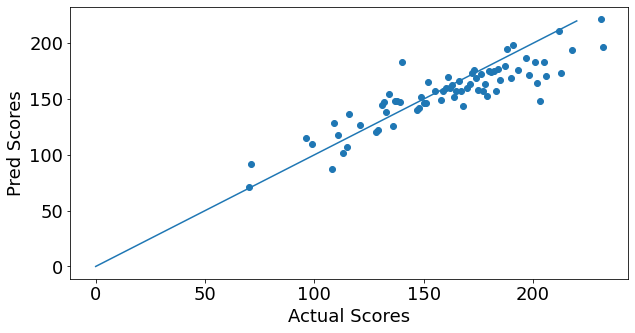

In [121]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})
plt.scatter(df_pred['Actual'], df_pred['Predict'])
plt.plot([0,120,160,200,220], [0,120,160,200,220])
plt.xlabel('Actual Scores')
plt.ylabel('Pred Scores')
plt.plot()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/IPL Score_Analysis/Plots/svr_2019.png')
plt.show()

In [122]:
# test
y_pred = svr.predict(setst)
accuracy, df_pred, mean_sq_err, r2score = new_strat(y_pred, yt1)
print('The accuracy is ' + str(accuracy)+'%')
print('R2 score: '+ str(r2score)+ 'MSE: '+ str(mean_sq_err))

The accuracy is 57.14285714285714%
R2 score: 0.7683591606218134MSE: 257.9654498379375


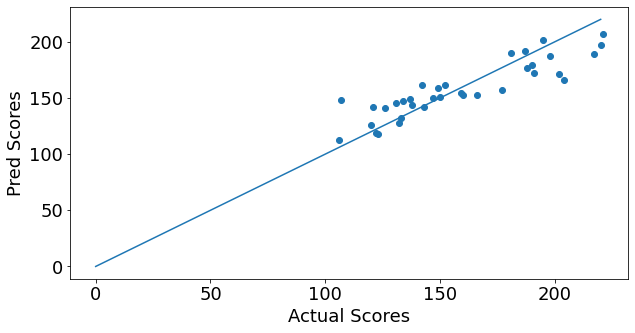

In [123]:
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})
plt.scatter(df_pred['Actual'], df_pred['Predict'])
plt.plot([0,120,160,200,220], [0,120,160,200,220])
plt.xlabel('Actual Scores')
plt.ylabel('Pred Scores')
plt.plot()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/IPL Score_Analysis/Plots/svr_2021.png')
plt.show()

Lets check if overfitting is an issue by removing some more not so important columns.

In [57]:
# without D/L & eliminiator
svr.fit(xft, y1train)
y_pred = svr.predict(tft)
print('Accuracy without D/L & eliminator: ' + str(custom_accuracy(y1test, y_pred, 12)))

Accuracy without D/L & eliminator: 50.3021978021978


Clearly, the accuracy decreased by 0.7% which isn't much but still we shouldn't remove those two columns therefore.

In [58]:
# CV
accuracy, df_pred, mean_sq_err, r2score = new_strat(y_pred, y1test)
print('The accuracy is ' + str(accuracy)+'%'+ ' without D/L and eliminator')
print('R2 score: '+ str(r2score)+ 'MSE: '+ str(mean_sq_err))

The accuracy is 58.9041095890411%
R2 score: 0.7562501387307661MSE: 295.7141847617436


In [59]:
# test
y_pred = svr.predict(xs)
accuracy, df_pred, mean_sq_err, r2score = new_strat(y_pred, yt1)
print('The accuracy is ' + str(accuracy)+'%'+ ' without D/L and eliminator')
print('R2 score: '+ str(r2score)+ 'MSE: '+ str(mean_sq_err))

The accuracy is 57.14285714285714%
R2 score: 0.7627113178036607MSE: 264.2551365663647


In [60]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [61]:
from sklearn.model_selection import GridSearchCV
param_grid_svr = {
              "C": [1,2,3,4,10],
              "kernel" : ['rbf'],
              "degree" : [1,2,3,4,5,6],
              "epsilon": [0.1,0.2]          
             }         
gr_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, verbose=2)
gr_svr.fit(xnewt, y1train)

In [62]:
gr_svr.best_params_
# best params : C=3

In [63]:
# def accuracy_winner(y_test, y_pred):
#   right = 0
#   l = len(y_pred)
#   for i in range(0,1):
#     if(abs(y_pred[i]-y_test[i]) <= 0.5):
#       right +=1
#   return ((right/l)*100)

# Winner Prediction

Since there are basically 13 teams, it is also actually possible to apply a regressor which will give an output from 0 to 13. And we will take the floor of that number as the class it belongs to and then compare the accuracy in the same way we did for total runs by creating a function that computes the average.

## Winner function

In [64]:
def predict_winner(id, y_pred, y_test):
  win = pd.DataFrame(y_pred, columns = ['Predict'])
  win['Actual'] = y_test
  frames = [id_test, win]
  final = pd.concat(frames, axis = 1)

  ar1 = final['id'].unique()
  winner = pd.DataFrame()

  for items in ar1:
    try2 = final[final.id == items]
    # try2.drop(columns = 'id', inplace = True)
    hapi = try2.drop(columns = ['id']).reset_index(drop=True)
    result = (hapi.sum())/hapi.shape[0]
    res = result.values.reshape(1,2)
    winner = winner.append(pd.DataFrame(res))

  winner.rename(columns = {0: 'Predict',
                          1: 'Actual'
                          }, inplace = True)
  winner.reset_index(drop = True)

  winner['diff'] = abs(winner['Actual'] - winner['Predict'])
  to = winner.shape[0]
  final_words = ( ((winner[(winner['diff'])<1].shape[0])/to)*100 )
  return(final_words)

## Regression

### SVR

In [65]:
svr = SVR()
svr.fit(xft, y2train)

# cv
y_pred = svr.predict(tft)
predict_winner(id_test, y_pred, y2test)

45.76271186440678

Test set winner prediction

In [66]:
y_pred = svr.predict(xs)
predict_winner(tt_2021, y_pred, yt2)

89.83050847457628

In [67]:
svr.fit(xnewt, y2train)
y_pred = svr.predict(tnewt)
predict_winner(id_test, y_pred, y2test)

45.76271186440678

In [68]:
y_pred = svr.predict(setst)
predict_winner(id_test, y_pred, yt2)

88.13559322033898

###RF

In [70]:
rf = RandomForestRegressor()
rf.fit(xft, y2train)
y_pred = rf.predict(tft)
predict_winner(id_test, y_pred, y2test)

47.45762711864407

Test set winner prediction

In [71]:
y_pred = rf.predict(xs)
predict_winner(tt_2021, y_pred, yt2)

89.83050847457628

## Classifier

### RFC

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [73]:
clf = RandomForestClassifier()
clf.fit(xnewt, y2train)
y_pred = clf.predict(tnewt)
print(accuracy_score(y2test,y_pred))

0.3543956043956044


### SVC

In [74]:
from sklearn.svm import SVC

In [75]:
svc = SVC(C=0.05)
svc.fit(xnewt, y2train)
y_pred = svc.predict(tnewt)
print(accuracy_score(y2test,y_pred))

0.4967032967032967


In [76]:
y_pred = svc.predict(setst)
predict_winner(id_test, y_pred, yt2)

81.35593220338984